<center > <span style = "background-color: rgb(251, 160, 38); font-size: 32px;" > <b > NUCLIO DIGITAL SCHOOL - </b > MASTER EN DATA SCIENCE </span > </center >

<br >

<center > <a href = https: // nuclio.school/wp-content/uploads/2019/10/nucleoDS-newBlack.png > <img src = "https://nuclio.school/wp-content/uploads/2019/10/nucleoDS-newBlack.png" width = 400 height = 100 > <a/>


<hr style="height:5px;border-width:0;color:orange;background-color:orange">
<center> <span style="font-size: 26px;"> Modelos de Boosting para Series Temporales y aplicación de sktime </span> </center>

<span style="font-size: 16px;">

+ Sesión: **Boosting en Series Temporales y sktime**
+ Módulo: **Series Temporales**
+ Profesor: **Edu Gonzalo Almorox**

</span>

<br>

<hr style="height:5px;border-width:0;color:orange;background-color:orange">

# Introducción

In [1]:
#pip install catboost
#pip install xgboost
#pip install shap
#pip install sktime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Modelos de boosting


Los modelos de boosting son una clase de métodos de aprendizaje conjunto _ensemble learning_. Al igual que otras técnicas como el _bagging_ los modelos de boosting combinan las predicciones de varios modelos individuales (aka _weak learners_) para obtener mejores predicciones. En los modelos de boosting, cada árbol se considera como un modelo de regresión que busca minimizar la función de pérdida. La creación de árboles se hace de forma secuencial de manera que cada árbol corrige los errores de los árboles anteriores. Hay bastantes implementaciones de este tipo de algoritmos. Entre las más populares:

- `GradientBoostingRegressor`
- `XGBoost`
- `CatBoost`
- `LigthGBM`

En este notebook vemos la implementación de Catboost y XGBoost utilizando dos estrategias distintas. 

- 1. Predicción de la tasa de crecimiento para cada una de las observaciones

- 2. Utilización del enfoque `sktime`


# Predicción de las tasas de crecimiento

**Intuición**: Estimar cuánto van a crecer los pasajeros y añadir ese crecimiento _esperado_ a los valores observados

In [2]:
# Cargamos datos

link = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(link)
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
px.line(df, x = 'Month', y = 'Passengers')

## CatBoost 

Ajustamos dos modelos:

- Modelo Naive (es decir, sin ningún tipo de variable añadida)

- Modelo que incorpora características temporales de los datos (ej. tendencias, estacionalidad, etc...)


### Feature engineering

Para añadir las características al modelo. 


In [4]:
# Otra forma de obtener info referida al mes y al año cuando tienen un formato específico y se consideran strings

df['year'] = df.Month.str[0:4].astype(int)
df['month'] = df.Month.str[5:].astype(int)
df

,Month,Passengers,year,month
0,1949-01,112,1949,1
1,1949-02,118,1949,2
2,1949-03,132,1949,3
3,1949-04,129,1949,4
4,1949-05,121,1949,5
...,...,...,...,...
139,1960-08,606,1960,8
140,1960-09,508,1960,9
141,1960-10,461,1960,10
142,1960-11,390,1960,11


In [5]:
# Transformar los datos
# Nota: Cuidado con las transformaciones que se hacen en los datos, ya que se puede producir un data leak. 
# Creamos retardos de 1, 2, 3, 12 y 24
df['lag_1'] = df['Passengers'].shift(1)
df['lag_2'] = df['Passengers'].shift(2)
df['lag_3'] = df['Passengers'].shift(3)
df['lag_12'] = df['Passengers'].shift(12)
df['lag_24'] = df['Passengers'].shift(24)

df


,Month,Passengers,year,month,lag_1,lag_2,lag_3,lag_12,lag_24
0,1949-01,112,1949,1,NaN,NaN,NaN,NaN,NaN
1,1949-02,118,1949,2,112.0,NaN,NaN,NaN,NaN
2,1949-03,132,1949,3,118.0,112.0,NaN,NaN,NaN
3,1949-04,129,1949,4,132.0,118.0,112.0,NaN,NaN
4,1949-05,121,1949,5,129.0,132.0,118.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
139,1960-08,606,1960,8,622.0,535.0,472.0,559.0,505.0
140,1960-09,508,1960,9,606.0,622.0,535.0,463.0,404.0
141,1960-10,461,1960,10,508.0,606.0,622.0,407.0,359.0
142,1960-11,390,1960,11,461.0,508.0,606.0,362.0,310.0


In [6]:
columns_X = ['year', 'month'] # Variables exógenas. El XGBoost lleva mal las fechas, por eso dividimos en mes y año
columns_y = 'Passengers'
years_train = np.arange(1949,1959) # Definimos años de entrenamiento
years_test = [1959, 1960] # Definimos años  de test

### División en muestra de entrenamiento y evaluación

In [7]:
df.loc[df.year.isin(years_train), 'type'] = 'train'
df.loc[df.year.isin(years_test), 'type'] = 'test'
df

,Month,Passengers,year,month,lag_1,lag_2,lag_3,lag_12,lag_24,type
0,1949-01,112,1949,1,NaN,NaN,NaN,NaN,NaN,train
1,1949-02,118,1949,2,112.0,NaN,NaN,NaN,NaN,train
2,1949-03,132,1949,3,118.0,112.0,NaN,NaN,NaN,train
3,1949-04,129,1949,4,132.0,118.0,112.0,NaN,NaN,train
4,1949-05,121,1949,5,129.0,132.0,118.0,NaN,NaN,train
...,...,...,...,...,...,...,...,...,...,...
139,1960-08,606,1960,8,622.0,535.0,472.0,559.0,505.0,test
140,1960-09,508,1960,9,606.0,622.0,535.0,463.0,404.0,test
141,1960-10,461,1960,10,508.0,606.0,622.0,407.0,359.0,test
142,1960-11,390,1960,11,461.0,508.0,606.0,362.0,310.0,test


In [8]:
train_X = df[df.year.isin(years_train)][columns_X] # Variables exógenas train
train_y = df[df.year.isin(years_train)][columns_y]
test_X = df[df.year.isin(years_test) ][columns_X] # Variables exógenas test
test_y = df[df.year.isin(years_test) ][columns_y]

display(train_X.head(3))
display(train_y.head(3))
display(test_X.head(3))
display(test_y.head(3))


,year,month
0,1949,1
1,1949,2
2,1949,3


0    112
1    118
2    132
Name: Passengers, dtype: int64

,year,month
120,1959,1
121,1959,2
122,1959,3


120    360
121    342
122    406
Name: Passengers, dtype: int64

### Ajuste del modelo

In [9]:
model_cat = CatBoostRegressor(iterations=100,    # number of trees
                              learning_rate=0.1, # scale the contribution of each tree
                              depth=5)           # how many child nodes each parent node has

# learning rate: be aware of the size of the learning rate
#  - small learning rate: more trees, more time to train, higher accuracy but higher risk of underfitting
#  - big learning rate: less trees, less time to train, higher risk of overfitting and model instability


In [10]:

# Fit model
model_cat.fit(train_X, train_y, verbose = False) 
# Get predictions
preds = model_cat.predict(test_X) 
preds

array([327.2139691 , 326.81318323, 354.30925333, 353.38395705,
       371.9757976 , 432.13091373, 483.3854048 , 483.44694568,
       411.74310848, 355.75172394, 316.81483172, 334.24883231,
       327.2139691 , 326.81318323, 354.30925333, 353.38395705,
       371.9757976 , 432.13091373, 483.3854048 , 483.44694568,
       411.74310848, 355.75172394, 316.81483172, 334.24883231])

### Predicciones

In [11]:
#preds = model.predict(train_X) + model.predict(test_X)
# Predicciones in sample
df['Pax_pred'] = np.concatenate([model_cat.predict(train_X), model_cat.predict(test_X)])
df

,Month,Passengers,year,month,lag_1,lag_2,lag_3,lag_12,lag_24,type,Pax_pred
0,1949-01,112,1949,1,NaN,NaN,NaN,NaN,NaN,train,117.858311
1,1949-02,118,1949,2,112.0,NaN,NaN,NaN,NaN,train,117.386501
2,1949-03,132,1949,3,118.0,112.0,NaN,NaN,NaN,train,130.807528
3,1949-04,129,1949,4,132.0,118.0,112.0,NaN,NaN,train,125.396103
4,1949-05,121,1949,5,129.0,132.0,118.0,NaN,NaN,train,122.983242
...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08,606,1960,8,622.0,535.0,472.0,559.0,505.0,test,483.446946
140,1960-09,508,1960,9,606.0,622.0,535.0,463.0,404.0,test,411.743108
141,1960-10,461,1960,10,508.0,606.0,622.0,407.0,359.0,test,355.751724
142,1960-11,390,1960,11,461.0,508.0,606.0,362.0,310.0,test,316.814832


In [12]:
# Con el train va bien, con el test falla un poco más
px.line(df, x = 'Month', y = [ 'Passengers', 'Pax_pred'], line_dash = 'type')

### Evaluación


In [13]:


print('-------------------- Métricas de evaluación de la parte de entrenamiento y de test Modelo Naive -------------')



mae_train = mean_absolute_error(df[df['type'] == 'train']['Passengers'], df[df['type'] == 'train']['Pax_pred']).round(4)
mape_train = mean_absolute_percentage_error(df[df['type'] == 'train']['Passengers'], df[df['type'] == 'train']['Pax_pred']).round(4)
rmse_train = mean_squared_error(df[df['type'] == 'train']['Passengers'], df[df['type'] == 'train']['Pax_pred'], squared = True).round(4)


eval_train = [mae_train, mape_train, rmse_train]
display(pd.DataFrame(eval_train, index = ['MAE', 'MAPE', 'RMSE'], columns = ['eval_train']))

# Evaluación de la parte de test

mae_test = mean_absolute_error(df[df['type'] == 'test']['Passengers'], df[df['type'] == 'test']['Pax_pred']).round(4)
rmse_test = mean_squared_error(df[df['type'] == 'test']['Passengers'], df[df['type'] == 'test']['Pax_pred'], squared = True).round(4)
mape_test = mean_absolute_percentage_error(df[df['type'] == 'test']['Passengers'], df[df['type'] == 'test']['Pax_pred']).round(4)

eval_test = [mae_test, mape_test, rmse_test]
pd.DataFrame(eval_test, index = ['MAE', 'MAPE', 'RMSE'], columns = ['eval_test'])




-------------------- Métricas de evaluación de la parte de entrenamiento y de test Modelo Naive -------------


,eval_train
MAE,4.5619
MAPE,0.0201
RMSE,33.1000


,eval_test
MAE,72.9818
MAPE,0.1578
RMSE,6245.6485


In [14]:
px.line(df[['Pax_pred','Passengers']])

## CatBoost con tendencias

Vamos a modelar los pasajeros utilizando su tasa de (de)crecimiento a lo largo del tiempo. La tasa de crecimiento es la diferencia relativa entre el valor de los pasajeros en el tiempo presente y el periodo inmediatamente anterior. 

**Intuición**: Predecir la tasa de crecimiento (expresada como %) en lugar de el número (absoluto) de pasajeros y aplicar esa tasa de crecimiento estimada al valor de los pasajeros

### Feature Engineering

Hay que calcular la tasa de crecimiento entre los valores actuales y el valor inmediatamente anterior. 

In [15]:
# Diferencia en pasajeros (absoluta). Los de hoy con respecto ayer

df['inc_diff'] = df['Passengers'] - df['lag_1']
df

,Month,Passengers,year,month,lag_1,lag_2,lag_3,lag_12,lag_24,type,Pax_pred,inc_diff
0,1949-01,112,1949,1,NaN,NaN,NaN,NaN,NaN,train,117.858311,NaN
1,1949-02,118,1949,2,112.0,NaN,NaN,NaN,NaN,train,117.386501,6.0
2,1949-03,132,1949,3,118.0,112.0,NaN,NaN,NaN,train,130.807528,14.0
3,1949-04,129,1949,4,132.0,118.0,112.0,NaN,NaN,train,125.396103,-3.0
4,1949-05,121,1949,5,129.0,132.0,118.0,NaN,NaN,train,122.983242,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08,606,1960,8,622.0,535.0,472.0,559.0,505.0,test,483.446946,-16.0
140,1960-09,508,1960,9,606.0,622.0,535.0,463.0,404.0,test,411.743108,-98.0
141,1960-10,461,1960,10,508.0,606.0,622.0,407.0,359.0,test,355.751724,-47.0
142,1960-11,390,1960,11,461.0,508.0,606.0,362.0,310.0,test,316.814832,-71.0


In [16]:
# No hay tendencia, está todo en torno al 0
# Lo que hay que corregir es que tienen mucha dispersión a lo largo del tiempo
px.line(df['inc_diff'], title='Diferencia absoluta de pasajeros') 

In [17]:
# Percentage change of the passengers - relative difference. Diferencia relativa o tasa de crecimiento
df['inc_per'] =  (df['Passengers'] / df['lag_1']) -1 # Cociente entre valor actual y pasado -1
df

,Month,Passengers,year,month,lag_1,lag_2,lag_3,lag_12,lag_24,type,Pax_pred,inc_diff,inc_per
0,1949-01,112,1949,1,NaN,NaN,NaN,NaN,NaN,train,117.858311,NaN,NaN
1,1949-02,118,1949,2,112.0,NaN,NaN,NaN,NaN,train,117.386501,6.0,0.053571
2,1949-03,132,1949,3,118.0,112.0,NaN,NaN,NaN,train,130.807528,14.0,0.118644
3,1949-04,129,1949,4,132.0,118.0,112.0,NaN,NaN,train,125.396103,-3.0,-0.022727
4,1949-05,121,1949,5,129.0,132.0,118.0,NaN,NaN,train,122.983242,-8.0,-0.062016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08,606,1960,8,622.0,535.0,472.0,559.0,505.0,test,483.446946,-16.0,-0.025723
140,1960-09,508,1960,9,606.0,622.0,535.0,463.0,404.0,test,411.743108,-98.0,-0.161716
141,1960-10,461,1960,10,508.0,606.0,622.0,407.0,359.0,test,355.751724,-47.0,-0.092520
142,1960-11,390,1960,11,461.0,508.0,606.0,362.0,310.0,test,316.814832,-71.0,-0.154013


In [18]:
# La aplicación de la diferencia relativa nos permite abordar el problema de estacionariedad y dispersión
# También se puede aplicar logaritmos que lo veremos a continuación
px.line(df['inc_per'], title =  'Diferencia relativa de pasajeros') # inc_per es la tasa de crecimiento de los pasajeros

### División Train - Test

Añadimos información adicional contenida en los retardos

In [19]:

columns_X = ['year', 'month', 'lag_1', 'lag_2', 'lag_12',  'lag_1_inc','lag_2_inc', 'lag_12_inc'] # Incorporamos más variables. Solo incorporamos el 1, 2 y 12 porque hemos visto que son los realmente importantes
columns_y = 'inc_per'
year_train = 1958

# Lag the target (differenced) variable. Definimos los lag de arriba
df['lag_1_inc'] = df['inc_per'].shift(1)
df['lag_2_inc'] = df['inc_per'].shift(2)
df['lag_12_inc'] = df['inc_per'].shift(12)

train_X = df[(df.year <= year_train) & (~df[columns_y].isna())][columns_X] # Quitamos los nulos
train_y = df[(df.year <= year_train) & (~df[columns_y].isna())][columns_y]
test_X = df[df.year > year_train ][columns_X]
test_y = df[df.year > year_train ][columns_y]

display(train_X.head(3))
display(train_y.head(3))
display(test_X.head(3))
display(test_y.head(3))


,year,month,lag_1,lag_2,lag_12,lag_1_inc,lag_2_inc,lag_12_inc
1,1949,2,112.0,NaN,NaN,NaN,NaN,NaN
2,1949,3,118.0,112.0,NaN,0.053571,NaN,NaN
3,1949,4,132.0,118.0,NaN,0.118644,0.053571,NaN


1    0.053571
2    0.118644
3   -0.022727
Name: inc_per, dtype: float64

,year,month,lag_1,lag_2,lag_12,lag_1_inc,lag_2_inc,lag_12_inc
120,1959,1,337.0,310.0,340.0,0.087097,-0.136490,0.011905
121,1959,2,360.0,337.0,318.0,0.068249,0.087097,-0.064706
122,1959,3,342.0,360.0,362.0,-0.050000,0.068249,0.138365


120    0.068249
121   -0.050000
122    0.187135
Name: inc_per, dtype: float64

### Ajuste del modelo

In [20]:
model_trends = CatBoostRegressor(iterations=100,
                          learning_rate=0.1,
                          depth=5)

In [21]:
# Fit model
model_trends.fit(train_X, train_y,verbose = False )
# Get predictions
preds = model_trends.predict(test_X)

In [22]:
df.loc[1:,'Pax_pred_inc'] = np.concatenate([model_trends.predict(train_X), model_trends.predict(test_X)])
df

,Month,Passengers,year,month,lag_1,lag_2,lag_3,lag_12,lag_24,type,Pax_pred,inc_diff,inc_per,lag_1_inc,lag_2_inc,lag_12_inc,Pax_pred_inc
0,1949-01,112,1949,1,NaN,NaN,NaN,NaN,NaN,train,117.858311,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02,118,1949,2,112.0,NaN,NaN,NaN,NaN,train,117.386501,6.0,0.053571,NaN,NaN,NaN,0.068480
2,1949-03,132,1949,3,118.0,112.0,NaN,NaN,NaN,train,130.807528,14.0,0.118644,0.053571,NaN,NaN,0.087075
3,1949-04,129,1949,4,132.0,118.0,112.0,NaN,NaN,train,125.396103,-3.0,-0.022727,0.118644,0.053571,NaN,-0.013287
4,1949-05,121,1949,5,129.0,132.0,118.0,NaN,NaN,train,122.983242,-8.0,-0.062016,-0.022727,0.118644,NaN,-0.040490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08,606,1960,8,622.0,535.0,472.0,559.0,505.0,test,483.446946,-16.0,-0.025723,0.162617,0.133475,0.020073,0.002162
140,1960-09,508,1960,9,606.0,622.0,535.0,463.0,404.0,test,411.743108,-98.0,-0.161716,-0.025723,0.162617,-0.171735,-0.125359
141,1960-10,461,1960,10,508.0,606.0,622.0,407.0,359.0,test,355.751724,-47.0,-0.092520,-0.161716,-0.025723,-0.120950,-0.135367
142,1960-11,390,1960,11,461.0,508.0,606.0,362.0,310.0,test,316.814832,-71.0,-0.154013,-0.092520,-0.161716,-0.110565,-0.121304


In [23]:
# Vemos que se va ajustando bastante
px.line(df[1:], x = 'Month', y = [ 'inc_per', 'Pax_pred_inc'], line_dash = 'type', title = 'Tasa de crecimiento de pasajeros | Train vs Test')

In [24]:
# Deshacemos la tasa de crecimiento
# Pax_pred_inc_total 
df['Pax_pred_inc_total'] = df['lag_1'] * (df['Pax_pred_inc'] + 1) # Aplicamos a nuestro lag de ayer, la tasa de crecimiento de hoy, para ver cuántos hay hoy
df

,Month,Passengers,year,month,lag_1,lag_2,lag_3,lag_12,lag_24,type,Pax_pred,inc_diff,inc_per,lag_1_inc,lag_2_inc,lag_12_inc,Pax_pred_inc,Pax_pred_inc_total
0,1949-01,112,1949,1,NaN,NaN,NaN,NaN,NaN,train,117.858311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02,118,1949,2,112.0,NaN,NaN,NaN,NaN,train,117.386501,6.0,0.053571,NaN,NaN,NaN,0.068480,119.669731
2,1949-03,132,1949,3,118.0,112.0,NaN,NaN,NaN,train,130.807528,14.0,0.118644,0.053571,NaN,NaN,0.087075,128.274898
3,1949-04,129,1949,4,132.0,118.0,112.0,NaN,NaN,train,125.396103,-3.0,-0.022727,0.118644,0.053571,NaN,-0.013287,130.246152
4,1949-05,121,1949,5,129.0,132.0,118.0,NaN,NaN,train,122.983242,-8.0,-0.062016,-0.022727,0.118644,NaN,-0.040490,123.776839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08,606,1960,8,622.0,535.0,472.0,559.0,505.0,test,483.446946,-16.0,-0.025723,0.162617,0.133475,0.020073,0.002162,623.344467
140,1960-09,508,1960,9,606.0,622.0,535.0,463.0,404.0,test,411.743108,-98.0,-0.161716,-0.025723,0.162617,-0.171735,-0.125359,530.032243
141,1960-10,461,1960,10,508.0,606.0,622.0,407.0,359.0,test,355.751724,-47.0,-0.092520,-0.161716,-0.025723,-0.120950,-0.135367,439.233632
142,1960-11,390,1960,11,461.0,508.0,606.0,362.0,310.0,test,316.814832,-71.0,-0.154013,-0.092520,-0.161716,-0.110565,-0.121304,405.078654


In [25]:
# Vemos que se ajusta bastante bien
px.line(df[1:], x = 'Month', y = [ 'Passengers', 'Pax_pred_inc_total'], line_dash = 'type')

### Evaluación

In [26]:
print('-------------------- Métricas de evaluación de la parte de entrenamiento y de test considerando las diferencias relativas -------------')



mae_train = mean_absolute_error(df[1:][df[1:]['type'] == 'train']['Passengers'], df[1:][df[1:]['type'] == 'train']['Pax_pred_inc_total']).round(4)
rmse_train = mean_squared_error(df[1:][df[1:]['type'] == 'train']['Passengers'], df[1:][df[1:]['type'] == 'train']['Pax_pred_inc_total'], squared = True).round(4)
mape = mean_absolute_percentage_error(df[1:][df[1:]['type'] == 'train']['Passengers'], df[1:][df[1:]['type'] == 'train']['Pax_pred_inc_total']).round(4)

eval_train = [mae_train, mape_train, rmse_train]
display(pd.DataFrame(eval_train, index = ['MAE', 'MAPE', 'RMSE'], columns = ['eval_train']))

# Evaluación de la parte de test

mae_test = mean_absolute_error(df[df['type'] == 'test']['Passengers'], df[df['type'] == 'test']['Pax_pred_inc_total']).round(4)
rmse_test = mean_squared_error(df[df['type'] == 'test']['Passengers'], df[df['type'] == 'test']['Pax_pred_inc_total'], squared = True).round(4)
mape_test = mean_absolute_percentage_error(df[df['type'] == 'test']['Passengers'], df[df['type'] == 'test']['Pax_pred_inc_total']).round(4)

eval_test = [mae_test, mape_test, rmse_test]
pd.DataFrame(eval_test, index = ['MAE', 'MAPE', 'RMSE'], columns = ['eval_test'])



-------------------- Métricas de evaluación de la parte de entrenamiento y de test considerando las diferencias relativas -------------


,eval_train
MAE,3.8969
MAPE,0.0201
RMSE,23.3461


,eval_test
MAE,17.6987
MAPE,0.0382
RMSE,442.9964


## Interpretación del Modelo

Una de las características del modelo SHAP es su capacidad para proporcionar una interpretación global de las variables, mediante la cual podemos conocer la contribución positiva (o negativa) de cada variable con respecto al objetivo.

Un gráfico de importancia de variables muestra las variables más significativas en orden descendente. Las variables principales contribuyen más al modelo que las inferiores y, por lo tanto, tienen un alto poder predictivo. El eje X muestra el valor SHAP promedio.

Text(0.5, 1.0, 'Feature Importance')

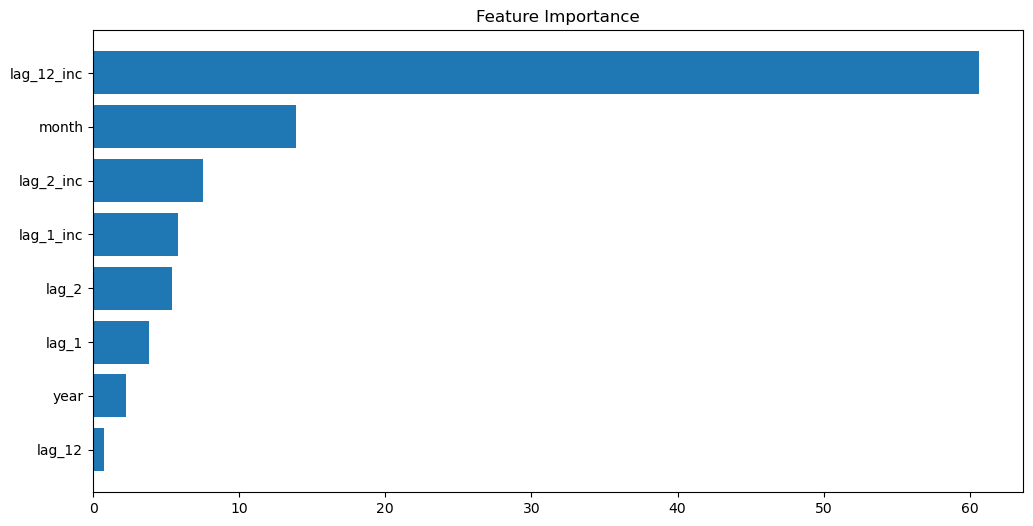

In [27]:
import matplotlib.pyplot as plt

# Get the feature importanc 
feature_importance = model_trends.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test_X.columns)[sorted_idx])
plt.title('Feature Importance')

# Estamos aplicando el modelo sobre el incremento relativo, por eso tiene más sentido que el valor relativo de hace un año tenga cierta relación
# La de hace dos meses también tiene más importancia que la de hace un mes

Otra forma de mostrar la importancia de las variables es utilizando la función summary_plot(). Este gráfico es más completo para comprender la asociación de las variables con la variable objetivo.

+ Impacto: La ubicación horizontal muestra si el efecto de ese valor está asociado con una predicción más alta o más baja.
+ Valor original: El color muestra si esa variable es alta (en rojo) o baja (en azul) para esa observación.
+ Correlación: Un alto nivel de contenido de "mes" tiene un impacto alto y negativo en el número de pasajeros. El "alto" se muestra mediante el color rojo, y el impacto "negativo" se muestra en el eje X (izquierda).

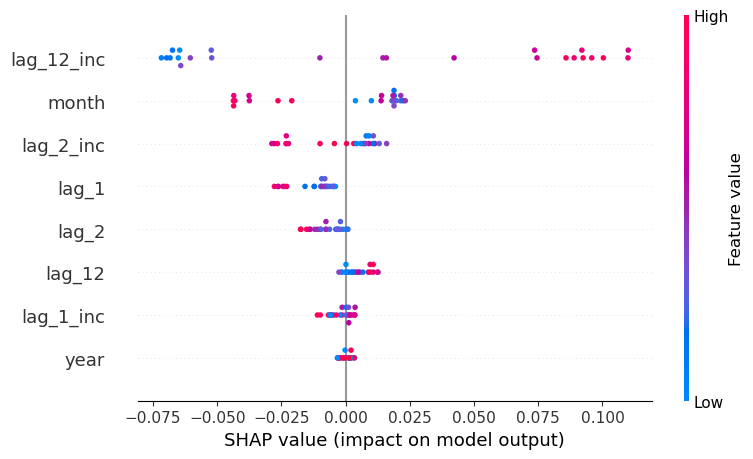

In [28]:
import shap
explainer = shap.TreeExplainer(model_trends) # No es un df, es el output de un modelo(donde lo has guardado)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X) # Usar test
# Cada uno de los puntos es una observación del df

## XGBoost



## Usando Sktime

`sktime` es un módulo bastante completo que permite probar diferentes modelos. Es una buena alternativa por las siguientes razones:

- **Reducción**: Estimadores de series temporales al estilo de scikit-learn

- **Ajuste**: El valor de los hiperparámetros se puede determinar utilizando estrategias de búsqueda en cuadrícula con validación cruzada temporal.

- **Evaluación**: Se incluyen varias métricas de rendimiento (por ejemplo, MAPE, MASE) que se pueden implementar fácilmente.

- **Pipelining**: Se pueden implementar pipelines que permiten la concatenación de transformadores para construir un único pronosticador.`



In [29]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_evaluation import evaluate

from sktime.forecasting.compose import make_reduction
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error


from xgboost import XGBRegressor 


from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import (
    TransformedTargetForecaster)
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, ExpandingWindowSplitter
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer, Detrender


import warnings 
warnings.filterwarnings('ignore')

El workflow a la hora de utilizar este módulo es similar a cualquier análisis de series temporales. 

1. [Cargar y explorar los datos](#data)
2. [Definir el horizonte de previsión](#forecasting-horizon)
3. [Definir el método de previsión](#forecasting-method)
4. [Ajustar las predicciones](#fitting)
5. [Obtener y evaluar las predicciones](#plotting)

### Cargar y explorar los datos <a class="anchor" id="data"></a>

Continuamos con los datos del epígrafe anterior.

In [30]:
df.head()

,Month,Passengers,year,month,lag_1,lag_2,lag_3,lag_12,lag_24,type,Pax_pred,inc_diff,inc_per,lag_1_inc,lag_2_inc,lag_12_inc,Pax_pred_inc,Pax_pred_inc_total
0,1949-01,112,1949,1,NaN,NaN,NaN,NaN,NaN,train,117.858311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02,118,1949,2,112.0,NaN,NaN,NaN,NaN,train,117.386501,6.0,0.053571,NaN,NaN,NaN,0.068480,119.669731
2,1949-03,132,1949,3,118.0,112.0,NaN,NaN,NaN,train,130.807528,14.0,0.118644,0.053571,NaN,NaN,0.087075,128.274898
3,1949-04,129,1949,4,132.0,118.0,112.0,NaN,NaN,train,125.396103,-3.0,-0.022727,0.118644,0.053571,NaN,-0.013287,130.246152
4,1949-05,121,1949,5,129.0,132.0,118.0,NaN,NaN,train,122.983242,-8.0,-0.062016,-0.022727,0.118644,NaN,-0.040490,123.776839


### Definir el horizonte de predicción  <a class="anchor" id="forecasting-horizon"></a>

Esta parte consiste en definir los períodos para los que se quiere realizar la predicción (que puede ser _in_ o _out sample_). Para ello es importante.

- Establecer la variable de fecha como índice de fecha.

    - Es importante asegurarse de que la frecuencia del índice está bien definida

- Dividir los datos entre el conjunto de entrenamiento y de evaluación (esto es especialmente importante )


A la hora de establecer el horizonte para la predicción, podemos hacerlo de dos formas. 

- array de `numpy` con enteros 

- `PeriodIndex()` 

    - En nuestro caso, esto significa que el modelo pronosticará el próximo mes, ya que definimos un índice mensual. 

    - Se define como *"Relativo"* si el índice está definido como una diferencia de fechas.

In [31]:
# Definimos índice
# Este paso para el XGBoost no es necesario

df_model = df[['Month', 'Passengers']]

df_model['Month'] = pd.to_datetime(df_model['Month'])
df_model = df_model.set_index('Month')

df_model.index = pd.DatetimeIndex(df_model.index).to_period('M')

display(df_model.info())
display(df_model.head())

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 144 entries, 1949-01 to 1960-12
Freq: M
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


None

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [32]:
# Hacemos el split de los datos con temporal_train_test_split

y_train, y_test = temporal_train_test_split(df_model, test_size=24) # El 24 es el número de períodos para tu evaluación
display(y_train.shape, y_train.head(2), y_train.tail(2))
display(y_test.shape, y_test.head(2), y_test.tail(2))

(120, 1)

,Passengers
Month,
1949-01,112
1949-02,118


,Passengers
Month,
1958-11,310
1958-12,337


(24, 1)

,Passengers
Month,
1959-01,360
1959-02,342


,Passengers
Month,
1960-11,390
1960-12,432


In [33]:
# Establecemos el horizonte de predicción
# Determinamos si va a ser dentro o fuera de la muestra
# Por ahora, solo aborda la muestra de evaluación

fh = ForecastingHorizon(y_test.index, is_relative=False) # Aquí indica que es dentro de la muestra
fh

ForecastingHorizon(['1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Month', is_relative=False)

### Ajuste del modelo <a class="anchor" id="fitting"></a>

Modelo XGboost _naive_ sin aplicar transformadores ni variables complementarias para explicar la demanda de pasajeros. 

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

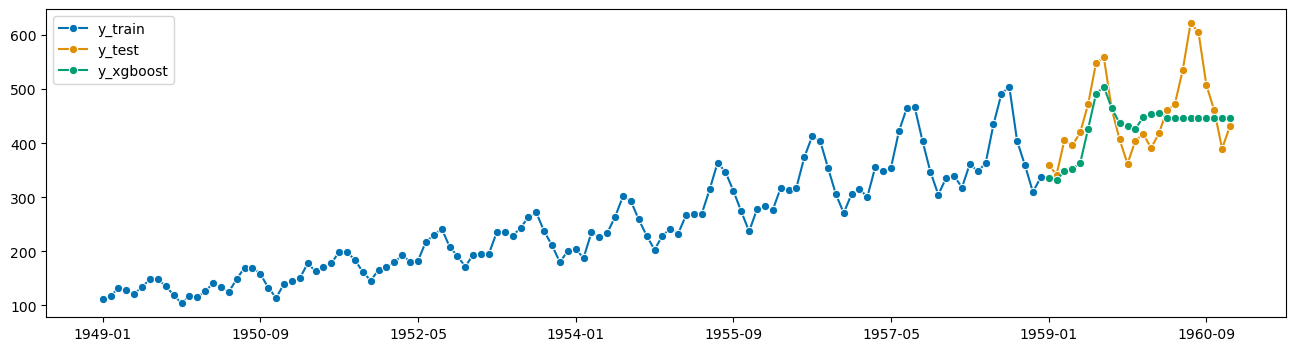

In [34]:
from xgboost import XGBRegressor 

xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
# Creamos el objeto forecaster
forecaster_xgb = make_reduction(xgb_regressor, strategy="recursive") # recursive(por defecto), direct, mulitoutput. La recursiva utiliza la información anterior para estimar el presente
forecaster_xgb.fit(y_train)
# Predecimos a partir del forecaster. Es in sample en este caso
y_pred_xgboost = forecaster_xgb.predict(fh)
plot_series(y_train, y_test, y_pred_xgboost, labels=["y_train", "y_test","y_xgboost"])


No hemos transformado y al hacerlo de forma recursiva no coge las variaciones pertinentes.

### Evaluación modelo <a class="anchor" id="plotting"></a>

In [35]:


mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgboost, symmetric=False)
mae_xgb = mean_absolute_error(y_test, y_pred_xgboost)
rmse_xgb = mean_squared_error(y_test, y_pred_xgboost, squared=True)


eval_xgb = [mape_xgb, mae_xgb, rmse_xgb]
pd.DataFrame(eval_xgb, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb'])


,eval_xgb
MAPE,0.106421
MAE,50.522198
RMSE,4254.578624


### Mejorar las predicciones

Hay espacio para mejorar las predicciones añadiendo transformadores y tuneando hiperparámetros

#### Transformadores

In [36]:
# Source: Full set of transformers is in here: https://sktime-backup.readthedocs.io/en/v0.13.0/api_reference/transformations.html#

# Definimos el regresor
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

# fit a forecaster with transformers aimed at deseasonalizing and detrending the data
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize_year", Deseasonalizer(model="multiplicative", sp=12)),
        ('LogTransformer', LogTransformer()), # Transformación logarítimica
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(xgb_regressor, window_length=12, scitype='tabular-regressor')), # window_length es la frecuencia de tus datos(diaria(365), mensual, semanal..)
        
    ]
    
)

forecaster.fit(y_train)
y_pred_transf = forecaster.predict(fh)


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

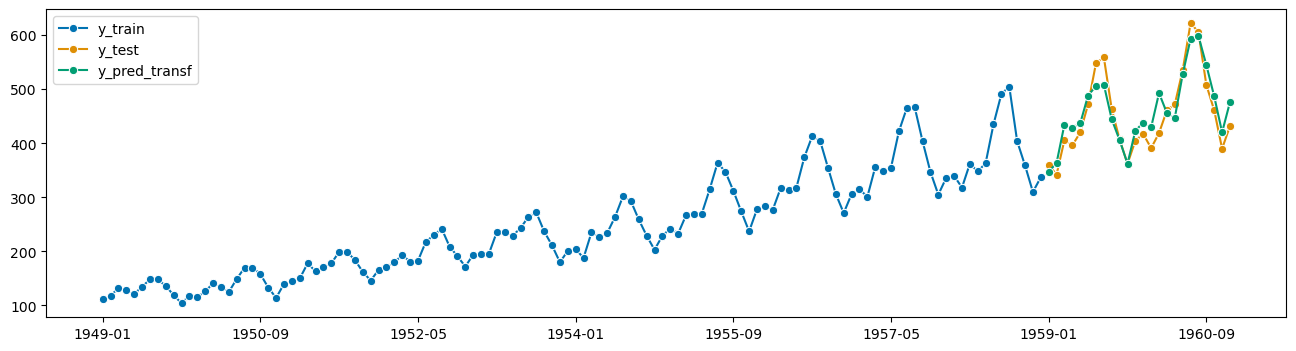

In [37]:
plot_series(y_train, y_test, y_pred_transf, labels=["y_train", "y_test", "y_pred_transf"])

In [38]:
mape_xgb_transf = mean_absolute_percentage_error(y_test, y_pred_transf, symmetric=False)
mae_xgb_transf = mean_absolute_error(y_test, y_pred_transf)
rmse_xgb_transf = mean_squared_error(y_test, y_pred_transf, squared=True)

eval_xgb_transf = [mape_xgb_transf, mae_xgb_transf, rmse_xgb_transf]
pd.DataFrame(eval_xgb_transf, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb'])

,eval_xgb
MAPE,0.056367
MAE,25.175614
RMSE,915.132435


####  Tunear hiperparametros, utilizar validación cruzada y re-entrenar

Hay que definir varias cosas

- El conjunto de hiperparámetros a tunear

- La forma en que vamos a dividir la serie temporal para llevar a cabo la validación cruzada. 







In [39]:
# Definimos el tamaño de la muestra para hacer la validación

validation_size = len(y_test)
validation_size

24

In [40]:
# Definimos muestra para la validación cruzada 
# Ventana que se va a ir ampliando con el tiempo
cv = ExpandingWindowSplitter(initial_window=36,
                                step_length=12, # Un año
                             fh=validation_size) # ¿Cuándo va a parar la validación? Cuando termine la muestra de test

In [41]:
param_grid = {
    'forecast__estimator__max_depth': [3, 5, 6, 10, 15], # Llamarlo forecast__estimator siempre
    'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__n_estimators': [100, 200, 300, 500, 1000]
}


rscv = ForecastingRandomizedSearchCV(forecaster, # Llamar al forecaster
                                     cv=cv, 
                                     param_distributions=param_grid,
                                     n_iter=100, # Número de iteraciones
                                     random_state=42,
                                     error_score='raise',
                                     n_jobs=-1)


Lo utilizo para ajustar y predecir con la validación cruzada y los transformadores.

In [42]:
result_cv = rscv.fit(y_train)

y_pred_transf_cv = rscv.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

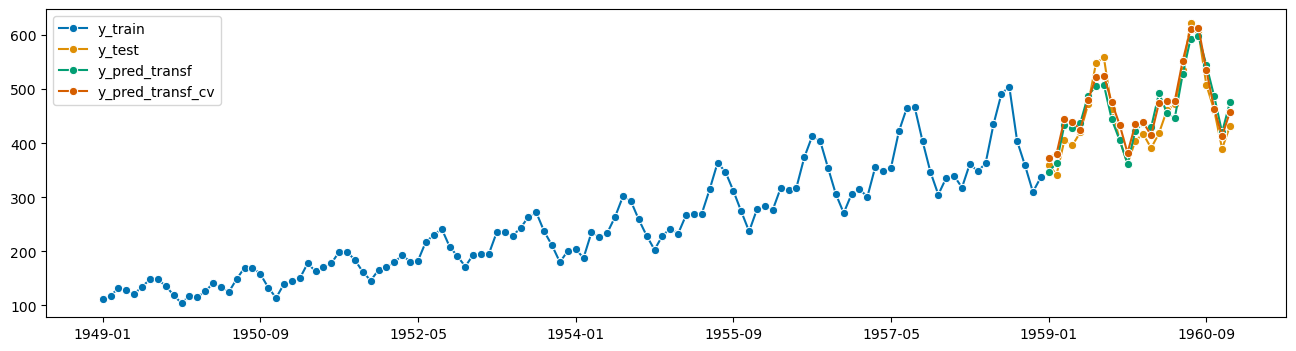

In [43]:
plot_series(y_train, y_test,  y_pred_transf, y_pred_transf_cv, labels=["y_train", "y_test", "y_pred_transf", "y_pred_transf_cv"])

Los transformadores crossvalidados vemos que se ajustan mejor.

In [44]:
# Evaluacion 


mape_xgb_transf_cv = mean_absolute_percentage_error(y_test, y_pred_transf_cv, symmetric=False)
mae_xgb_transf_cv = mean_absolute_error(y_test, y_pred_transf_cv)
rmse_xgb_transf_cv = mean_squared_error(y_test, y_pred_transf_cv, squared=True)

eval_xgb_transf_cv = [mape_xgb_transf_cv, mae_xgb_transf_cv, rmse_xgb_transf_cv]
pd.DataFrame(eval_xgb_transf_cv, index = ['MAPE', 'MAE', 'RMSE'], columns = ['eval_xgb_transf_cv'])

,eval_xgb_transf_cv
MAPE,0.052271
MAE,22.364487
RMSE,673.015363


Da peor error que el anterior, pese a que se ajusta mejor en el gráfico.

### Pronóstico fuera de la muestra

In [45]:
fhos = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("1959-01", periods=36, freq="M")), is_relative=False
)
fhos

ForecastingHorizon(['1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12',
             '1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12'],
            dtype='period[M]', is_relative=False)

In [46]:
rscv.fit(y_train)
y_pred_transf_oos = rscv.predict(fhos)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

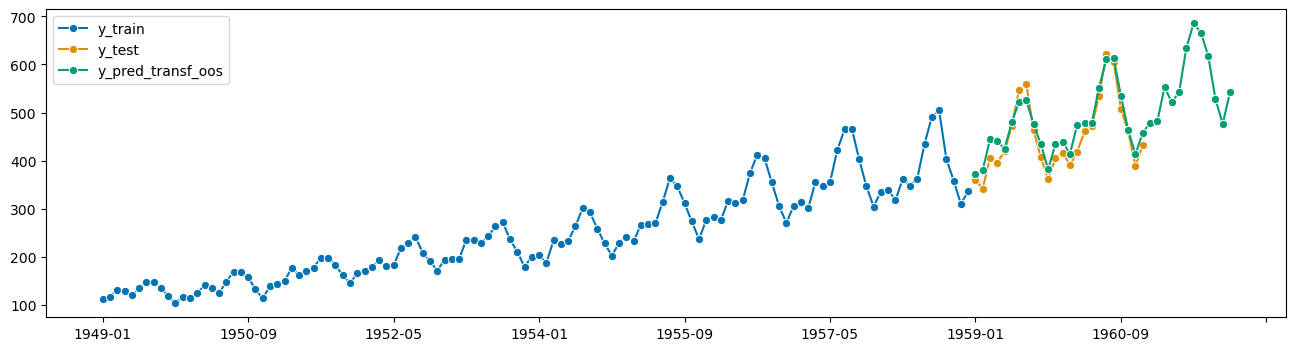

In [47]:
plot_series(y_train, y_test, y_pred_transf_oos, labels=["y_train", "y_test", "y_pred_transf_oos"])
